In [2]:
import pandas as pd
import numpy as np
import sys
import os
import nltk
import gensim
import csv
import re
import pickle as pkl
import string

from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, classification_report
from sklearn.tree import DecisionTreeClassifier

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from spacy.lang.nl import Dutch
import nl_bertje

from collections import Counter

import plotly

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff



In [3]:

import nltk
#nltk.download('stopwords')

### Preprocessing of the df

In [4]:
#load sentencizer
nlp = Dutch()
nlp.add_pipe(nlp.create_pipe('sentencizer'))
nlp = nl_bertje.load()



In [5]:
def extract_features_labels(trainingfile):
    """trainingfile moet df zijn"""
    data = []
    targets = []
    index = -1
    new_dict = dict()
    features_list = []
    vector_list = []
    text_list = []
    shape_list = []
    
    trainingfile = trainingfile.values.tolist()
    
    for row in trainingfile:
    
        text = row[-2]
        text = str(text).replace('\n\n', '')
        #print(text, len(text))
        if len(text) > 5:
            vector = nlp(text).vector
            #print(vector.shape)
            shape_list.append(vector.shape)
        else:
            vector = np.zeros(768)
            #print(vector.shape)
            shape_list.append(vector.shape)
        label = row[-1]
        feature_dict = {
            'text' : text,
            #'vector' : vector,
            }
        
        #text_without_sw = 
        #print(text)
        #print(vector)
        data.append(feature_dict)
        targets.append(label)
        text_list.append(text)
        vector_list.append(vector)
            
    return data, targets, vector_list, text_list, shape_list        
        

## SVM classification

In [6]:
def create_classifier(train_features, train_targets):
    model = svm.SVC(kernel='rbf', C=5000, gamma='scale')
    vec = DictVectorizer()
    features_vectorized = vec.fit_transform(train_features)
    model = model.fit(features_vectorized, train_targets)
    #model = model.fit(train_features, train_targets)
    return model, vec

def classify_data(model, vec, inputdata, outputfile):
    #/features = extract_features_and_labels(inputdata)[0]
    features_vec = vec.transform(inputdata)
    predictions = model.predict(features_vec)
     
    return predictions

### Read in data

In [7]:
#trainingfile = pd.read_excel('Annotation_sample_OB_ingevuld_Oele.xlsm', engine='openpyxl')
trainingfile = pd.read_csv('DatasetSA_classification.csv', sep=';')
trainingfile.shape
trainingfile.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'FileCode', 'FileName',
       'FileCaption', 'Sample_nr', 'Text', 'len_text', 'whitespace_count',
       'newline_count', 'perc_newline', 'perc_whitespace', 'total_nr_sent',
       'sent_index_in_tb', 'cleaned_text', 'SA Label'],
      dtype='object')

In [8]:
trainingfile = trainingfile[['FileName', 'FileCaption', 'Text', 'len_text', 'cleaned_text', 'SA Label' ]]
trainingfile = trainingfile.dropna(subset=['SA Label'])
trainingfile = trainingfile.drop_duplicates(subset= 'cleaned_text')
print(trainingfile.shape)
trainingfile.iloc[0]

(2119, 6)


FileName                                               NCV113.xml
FileCaption     NCV113 Meded pandrecht en inning verpande vord...
Text            Betreft: Mededeling pandrecht en inning verpan...
len_text                                                     1724
cleaned_text    Mededeling pandrecht en inning verpande vorder...
SA Label                                   informative/persuasive
Name: 0, dtype: object

### Define features and targets + Encode labels

In [9]:
labelencoder = LabelEncoder()


In [10]:
X = extract_features_labels(trainingfile)[0]


In [11]:
y = extract_features_labels(trainingfile)[1]
y_enc = labelencoder.fit_transform(y)

In [12]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=trainingfile['SA Label'])

X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size= 0.5, random_state=42, stratify=y_valtest)

In [13]:
print(Counter(y_train)) ##distribution of the labels
print(Counter(y_val))
print(Counter(y_test))

Counter({3: 900, 2: 390, 1: 142, 0: 137, 4: 126})
Counter({3: 113, 2: 48, 1: 18, 0: 17, 4: 16})
Counter({3: 112, 2: 49, 1: 18, 0: 17, 4: 16})


In [14]:
model, vec = create_classifier(X_train, y_train)

### Evaluation development set

In [15]:
pred = classify_data(model, vec, X_val, 'pred.csv')

In [16]:
Counter(pred) ##distribution of the predicted labels


Counter({3: 212})

In [17]:
print(classification_report(labelencoder.inverse_transform(y_val.tolist()),labelencoder.inverse_transform(pred.tolist())))

                        precision    recall  f1-score   support

            commissive       0.00      0.00      0.00        17
           declarative       0.00      0.00      0.00        18
 directive/instructive       0.00      0.00      0.00        48
informative/persuasive       0.53      1.00      0.70       113
         miscellaneous       0.00      0.00      0.00        16

              accuracy                           0.53       212
             macro avg       0.11      0.20      0.14       212
          weighted avg       0.28      0.53      0.37       212



/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[[113  48  17  18  16]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


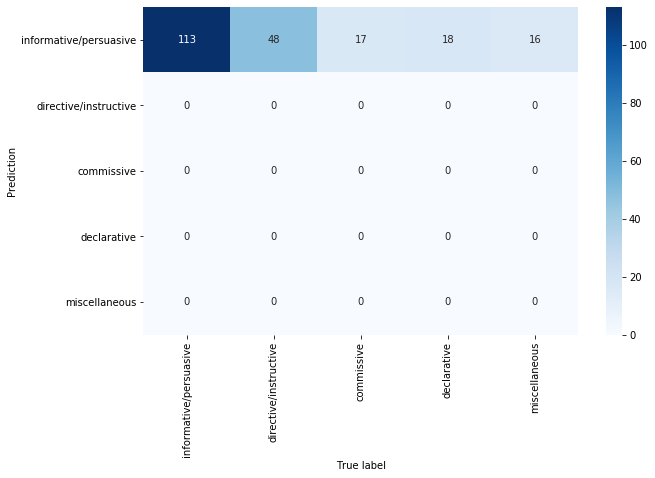

In [18]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(labelencoder.inverse_transform(pred.tolist()), labelencoder.inverse_transform(y_val.tolist()), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/SVM_val.png')

### Evaluation on test set

In [19]:
pred = classify_data(model, vec, X_test, 'pred.csv')

In [20]:
print(Counter(pred))

Counter({3: 212})


In [21]:
print(classification_report(labelencoder.inverse_transform(y_test.tolist()),labelencoder.inverse_transform(pred.tolist())))

                        precision    recall  f1-score   support

            commissive       0.00      0.00      0.00        17
           declarative       0.00      0.00      0.00        18
 directive/instructive       0.00      0.00      0.00        49
informative/persuasive       0.53      1.00      0.69       112
         miscellaneous       0.00      0.00      0.00        16

              accuracy                           0.53       212
             macro avg       0.11      0.20      0.14       212
          weighted avg       0.28      0.53      0.37       212



/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[[112  49  17  18  16]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


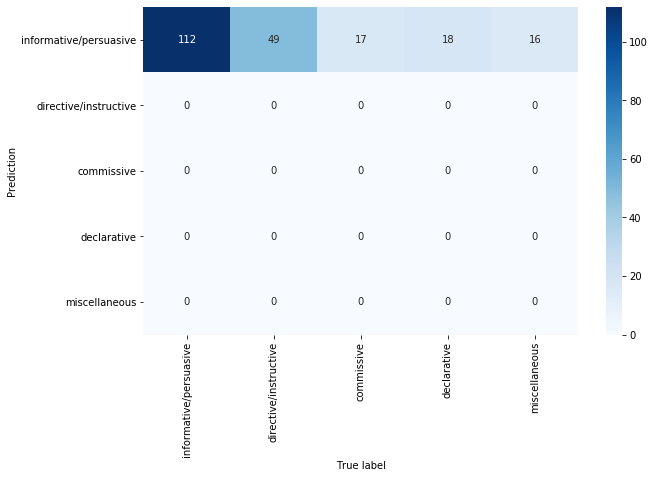

In [22]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(labelencoder.inverse_transform(pred.tolist()), labelencoder.inverse_transform(y_test.tolist()), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/SVM_test.png')

## Evaluation SVM per domain

In [23]:
def cm_subset(df, true, pred, label, column):
    df["pred"] = pred
    df = df[df[column] == label]
    true = df["SA Label"].tolist()
    pred = df["pred"].tolist()
    
    print(classification_report(true,pred))
    
    labels=['informative/persuasive','directive/instructive', 'commissive', 'miscellaneous'] ##add declarative later
    x = labels
    y = labels

    cm = confusion_matrix(true, pred, normalize=None, labels=labels)
    #z_text = [[str(y) for y in x] for x in cm]

    #print(cm)
    #fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
    #fig.show("notebook")

    plt.figure(figsize = (10,7))
    plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues')
    plot.set_xlabel("True label")
    plot.set_ylabel("Prediction")
    plt.tight_layout(pad=2)
    plot

### Development set

### Test set


## Taking context into consideration

In [24]:
def extract_features_labels_C(trainingfile):
    """trainingfile moet df zijn"""
    data = []
    targets = []
    index = -1
    new_dict = dict()
    features_list = []
    vector_list = []
    text_list = []
    shape_list = []
    
    trainingfile = trainingfile.values.tolist()
    
    for row in trainingfile:
    
        text = row[-2]
        text = str(text).replace('\n\n', '')
        context = row[2]
        context =str(context).replace('\n\n', '')
        #print(text, len(text))
        if len(text) > 5:
            vector = nlp(text).vector
            #print(vector.shape)
            shape_list.append(vector.shape)
        else:
            vector = np.zeros(768)
            #print(vector.shape)
            shape_list.append(vector.shape)
        label = row[-1]
        feature_dict = {
            'text' : text,
            'context' : context,
            }
        
        #text_without_sw = 
        #print(text)
        #print(vector)
        data.append(feature_dict)
        targets.append(label)
        text_list.append(text)
        vector_list.append(vector)
            
    return data, targets, vector_list, text_list, shape_list    


def create_classifier(train_features, train_targets):
    model = svm.SVC()
    vec = DictVectorizer()
    features_vectorized = vec.fit_transform(train_features)
    model = model.fit(features_vectorized, train_targets)
    #model = model.fit(train_features, train_targets)
    return model, vec



def classify_data(model, vec, inputdata, outputfile):
    #/features = extract_features_and_labels(inputdata)[0]
    features_vec = vec.transform(inputdata)
    predictions = model.predict(features_vec)
     
    return predictions

In [25]:
X = extract_features_labels_C(trainingfile)[0]


In [26]:
y = extract_features_labels_C(trainingfile)[1]
y_enc = labelencoder.fit_transform(y)



In [27]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y_enc, test_size=0.8, random_state=42, stratify=trainingfile['SA Label'])

X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size= 0.5, random_state=42, stratify=y_valtest)

In [28]:
model, vec = create_classifier(X_train, y_train)

In [29]:
pred = classify_data(model, vec, X_val, 'pred.csv')

In [30]:
print(classification_report(labelencoder.inverse_transform(y_val.tolist()),labelencoder.inverse_transform(pred.tolist())))

                        precision    recall  f1-score   support

            commissive       0.00      0.00      0.00        68
           declarative       0.00      0.00      0.00        72
 directive/instructive       0.29      0.04      0.07       195
informative/persuasive       0.53      0.96      0.68       450
         miscellaneous       0.00      0.00      0.00        63

              accuracy                           0.52       848
             macro avg       0.16      0.20      0.15       848
          weighted avg       0.35      0.52      0.38       848



/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[[433 187  67  70  63]
 [ 17   8   1   2   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


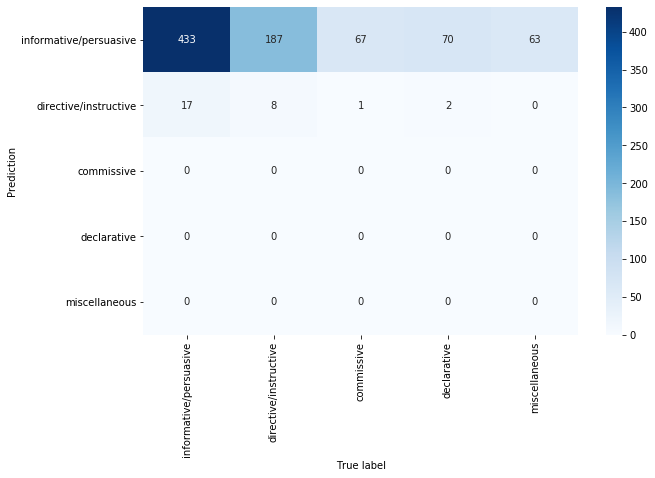

In [31]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(labelencoder.inverse_transform(pred.tolist()), labelencoder.inverse_transform(y_val.tolist()), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/SVMcontext_val.png')

In [32]:
pred = classify_data(model, vec, X_test, 'pred.csv')

In [33]:
print(classification_report(labelencoder.inverse_transform(y_test.tolist()),labelencoder.inverse_transform(pred.tolist())))

                        precision    recall  f1-score   support

            commissive       0.00      0.00      0.00        69
           declarative       0.00      0.00      0.00        71
 directive/instructive       0.50      0.07      0.12       195
informative/persuasive       0.53      0.98      0.69       450
         miscellaneous       0.00      0.00      0.00        63

              accuracy                           0.53       848
             macro avg       0.21      0.21      0.16       848
          weighted avg       0.40      0.53      0.39       848



/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[[439 182  69  71  61]
 [ 11  13   0   0   2]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


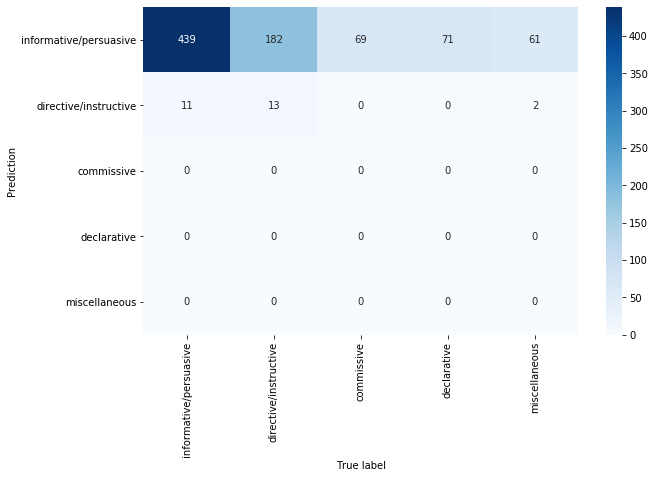

In [34]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(labelencoder.inverse_transform(pred.tolist()), labelencoder.inverse_transform(y_test.tolist()), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/SVMcontext_test.png')

## SVM with SAV features

In [35]:
SAV_feature_df = pd.read_csv('SAV_features.csv', sep= ';')
SAV_feature_df = SAV_feature_df[['informative/persuasive', 'directive/instructive', 'commissive', 'declarative', 'miscellaneous']]

In [36]:
trainingfile_ens = pd.DataFrame()
trainingfile_ens = pd.concat([trainingfile, SAV_feature_df], axis=1)


### adapt feature extraction function

In [37]:
def extract_features_labels_ens(trainingfile):
    data = []
    targets = []
    index = -1
    new_dict = dict()
    features_list = []
    vector_list = []
    text_list = []
    shape_list = []
    
    trainingfile = trainingfile.values.tolist()
    
    for row in trainingfile:
    
        text = row[4]
        text = str(text).replace('\n\n', '')
        #print(text, len(text))
        if len(text) > 5:
            vector = nlp(text).vector
            #print(vector.shape)
            shape_list.append(vector.shape)
        else:
            vector = np.zeros(768)
            #print(vector.shape)
            shape_list.append(vector.shape)
        label = row[-6]
        inf_pers = row[-5]
        dir_ins = row[-4]
        comm = row[-3]
        decl = row[-2]
        misc = row[-1]

        feature_dict = {
            'text' : text,
            'informative/persuasive' : inf_pers,
            'directive/instructive' : dir_ins,
            'commissive' : comm,
            'declarative' : decl,
            'miscellaneous' : misc
        }
        
        #text_without_sw = 
        
        data.append(feature_dict)
        targets.append(label)
        text_list.append(text)
        vector_list.append(vector)
            
    return data, targets, vector_list, text_list, shape_list        
      

In [38]:
X = extract_features_labels_ens(trainingfile_ens)[0]
y = extract_features_labels_ens(trainingfile_ens)[1]
y_enc = labelencoder.fit_transform(y)


In [39]:
print(Counter(y))

Counter({'informative/persuasive': 1125, 'directive/instructive': 487, 'declarative': 178, 'commissive': 171, 'miscellaneous': 158})


In [40]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=trainingfile_ens['SA Label'])

X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size= 0.5, random_state=42, stratify=y_valtest)
  


### Evaluation on developmet set

In [41]:
model, vec = create_classifier(X_train, y_train)

pred = classify_data(model, vec, X_val, 'pred.csv')

print(classification_report(labelencoder.inverse_transform(y_val.tolist()),labelencoder.inverse_transform(pred.tolist())))

                        precision    recall  f1-score   support

            commissive       0.00      0.00      0.00        17
           declarative       0.00      0.00      0.00        18
 directive/instructive       0.58      0.15      0.23        48
informative/persuasive       0.56      0.97      0.71       113
         miscellaneous       0.00      0.00      0.00        16

              accuracy                           0.55       212
             macro avg       0.23      0.22      0.19       212
          weighted avg       0.43      0.55      0.43       212



/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[[110  39  15  18  15]
 [  2   7   2   0   1]
 [  1   2   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


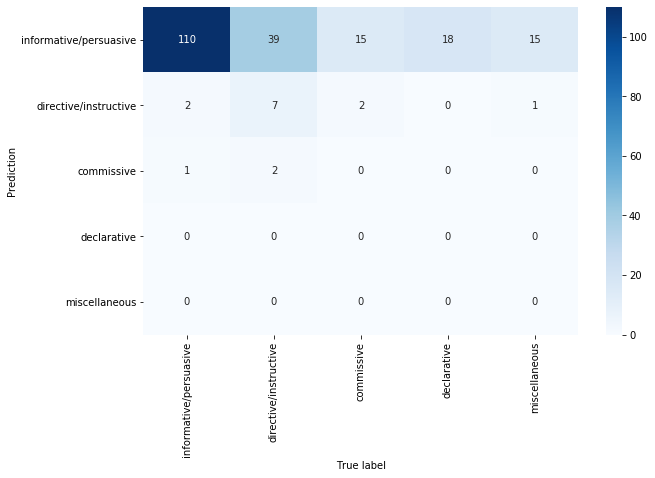

In [42]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(labelencoder.inverse_transform(pred.tolist()), labelencoder.inverse_transform(y_val.tolist()), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/SVM_RBS_val.png')

### Evaluation on test set

In [43]:
pred = classify_data(model, vec, X_test, 'pred.csv')

print(classification_report(labelencoder.inverse_transform(y_test.tolist()),labelencoder.inverse_transform(pred.tolist())))

                        precision    recall  f1-score   support

            commissive       0.00      0.00      0.00        17
           declarative       0.00      0.00      0.00        18
 directive/instructive       0.33      0.10      0.16        49
informative/persuasive       0.54      0.94      0.68       112
         miscellaneous       0.00      0.00      0.00        16

              accuracy                           0.52       212
             macro avg       0.17      0.21      0.17       212
          weighted avg       0.36      0.52      0.40       212



/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[[105  42  14  18  16]
 [  7   5   3   0   0]
 [  0   2   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


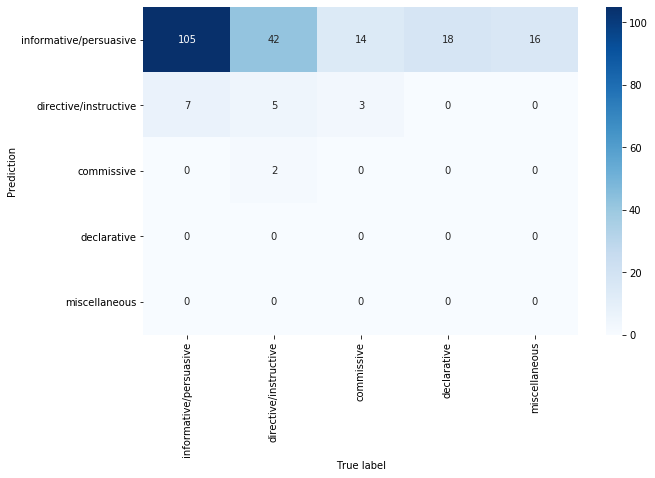

In [44]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(labelencoder.inverse_transform(pred.tolist()), labelencoder.inverse_transform(y_test.tolist()), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/SVM_RBS_test.png')

## Classification Decision tree 

In [45]:
trainingfile.iloc[0]

FileName                                               NCV113.xml
FileCaption     NCV113 Meded pandrecht en inning verpande vord...
Text            Betreft: Mededeling pandrecht en inning verpan...
len_text                                                     1724
cleaned_text    Mededeling pandrecht en inning verpande vorder...
SA Label                                   informative/persuasive
Name: 0, dtype: object

In [46]:
clf_dt = DecisionTreeClassifier(max_depth=15, random_state = 42)





In [47]:
X = extract_features_labels(trainingfile)[2]
y = extract_features_labels(trainingfile)[1]
y_enc = labelencoder.fit_transform(y)



In [48]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=trainingfile['SA Label'])

X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size= 0.5, random_state=42, stratify=y_valtest)
  

In [49]:
X[0][:10]

array([ 41.056774, -34.8903  , -19.432333, -17.847483,  -8.63696 ,
       -70.38027 ,  10.204559, -40.37361 , -22.496553,  40.299805],
      dtype=float32)

In [50]:
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, random_state=42)

## Evaluation on development set

In [51]:
pred_dt = clf_dt.predict(X_val)
print(clf_dt.get_depth())

print(clf_dt)

15
DecisionTreeClassifier(max_depth=15, random_state=42)


In [52]:
print(classification_report(labelencoder.inverse_transform(y_val.tolist()),labelencoder.inverse_transform(pred_dt.tolist())))


Counter(pred_dt)

                        precision    recall  f1-score   support

            commissive       0.12      0.12      0.12        17
           declarative       0.08      0.06      0.06        18
 directive/instructive       0.49      0.48      0.48        48
informative/persuasive       0.58      0.62      0.60       113
         miscellaneous       0.36      0.31      0.33        16

              accuracy                           0.48       212
             macro avg       0.32      0.32      0.32       212
          weighted avg       0.46      0.48      0.47       212



Counter({3: 121, 2: 47, 1: 13, 0: 17, 4: 14})

[[70 18  9 14 10]
 [15 23  6  2  1]
 [ 9  5  2  1  0]
 [11  1  0  1  0]
 [ 8  1  0  0  5]]


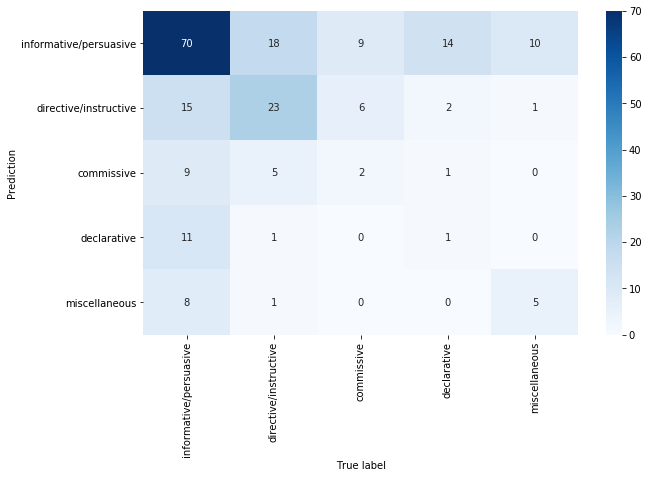

In [53]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(labelencoder.inverse_transform(pred_dt.tolist()), labelencoder.inverse_transform(y_val.tolist()), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/DT_val.png')

## Evaluation on test set

In [54]:
pred_dt = clf_dt.predict(X_test)
print(clf_dt.get_depth())

print(classification_report(labelencoder.inverse_transform(y_test.tolist()),labelencoder.inverse_transform(pred_dt.tolist())))


Counter(pred_dt)


15
                        precision    recall  f1-score   support

            commissive       0.18      0.24      0.21        17
           declarative       0.12      0.17      0.14        18
 directive/instructive       0.47      0.37      0.41        49
informative/persuasive       0.60      0.60      0.60       112
         miscellaneous       0.19      0.19      0.19        16

              accuracy                           0.45       212
             macro avg       0.31      0.31      0.31       212
          weighted avg       0.46      0.45      0.45       212



Counter({3: 112, 4: 16, 0: 22, 1: 24, 2: 38})

[[67 13  9 13 10]
 [16 18  2  1  1]
 [10  8  4  0  0]
 [10  7  2  3  2]
 [ 9  3  0  1  3]]


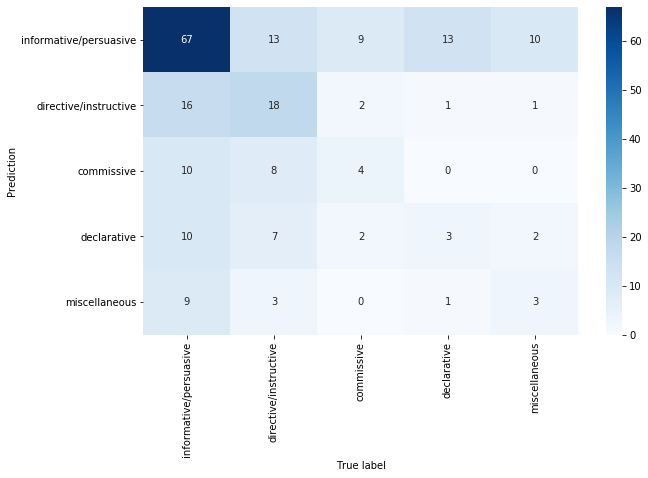

In [55]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(labelencoder.inverse_transform(pred_dt.tolist()), labelencoder.inverse_transform(y_test.tolist()), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/DT_test.png')

### Error analysis

In [56]:
error_analysis = pd.DataFrame### per domain?

In [57]:
trainingfile = pd.read_csv('DatasetSA_classification.csv', sep=';')
X = trainingfile[["cleaned_text"]]
y = trainingfile['SA Label']

In [58]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.2, random_state=42, stratify=trainingfile['SA Label'])

X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size= 0.5, random_state=42, stratify=y_valtest)
  

In [59]:
error_analysis= X_test[['cleaned_text']]

In [60]:
error_analysis['gold_label'] = y_test

In [61]:
error_analysis['prediction'] = labelencoder.inverse_transform(pred_dt)

In [62]:
training = X_train
training["label"] = y_train

In [223]:
count_U= 0

for text in training[training["label"] != 'directive/instructive'].values:
    #print(text)
    if "u " in str(text).lower():
        count_U += 1
    
print(count_U)
print(training[training['label'] != 'directive/instructive'].shape)

527
(1305, 2)


In [189]:
counter = 0
error_counter = 0
values_list = []
values_counter = 0
zero_dict_counter = 0
u_counter = 0
utwo_counter = 0
for row in error_analysis.values:
    counter += 1
    if row[-1] != row[-2]:
        error_counter += 1
        if row[-1] == 'declarative':
            
                
                print(row)
        if error_counter == 10:
            break
                #print()
                #if "de Belastingdienst " in row[0]:
                    #u_counter += 1
        #print("Sentence: ", row[0])
        #print("gold label: ", row[-2], '-- predicted label: ', row[-1])
    #            #print()
    #if row[-1] == row[-2]:
    #if row[-2] == 'commissive':
                #if 'u ' in str(row[0]).lower():
                #print(row)
            #print()
                   # u_counter += 1
    if ' de belastingdienst' in str(row[0]).lower():
            utwo_counter += 1
            #print(row)
        
            
            
        #print(row)
            print()
        
print("FINAL COUNTS")   
print("U:", u_counter )
print("counter: ", counter)
print("errors: ", error_counter)
print(utwo_counter)

['Vergunning intrekken of wijzigen Ik kan uw vergunning intrekken of wijzigen.'
 'informative/persuasive' 'declarative']
['toch loonheffingen en omzetbelasting diende af te dragen, dan aanvaardt de Belastingdienst geen aansprakelijkheid voor eventuele nadelige gevolgen die naar aanleiding van deze beschikking ontstaan zijn.'
 'commissive' 'declarative']

FINAL COUNTS
U: 0
counter:  16
errors:  10
1


In [105]:
training_data = X_train

In [111]:
training_data['label'] = y_train

In [164]:
comm_df = training_data[training_data['label'] == 'commissive']

In [191]:
comm_df[:3]

,cleaned_text,label,ik u
1698,Als ik besluit aan uw beroep tegemoet te komen...,commissive,True
607,"Als het bestreden bedrag nog niet is voldaan, ...",commissive,True
1062,"Als u niet aan deze voorwaarden voldoet, kan i...",commissive,True


In [170]:
print(Counter(comm_df['cleaned_text'].str.contains(' de Belastingdienst ')))
print(Counter(training_data['cleaned_text'].str.contains(' de Belastingdienst ')))

Counter({False: 131, True: 6})
Counter({False: 1660, True: 35})


In [171]:
training_data['ik u'] = training_data['cleaned_text'].str.contains(' de Belastingdienst ')

In [172]:
Counter(training_data[training_data['ik u']==True].sort_values(by=['label'])['label'])

Counter({'commissive': 6,
         'declarative': 2,
         'directive/instructive': 5,
         'informative/persuasive': 22})

In [173]:
Counter(training_data['label'])

Counter({'informative/persuasive': 900,
         'declarative': 142,
         'directive/instructive': 390,
         'commissive': 137,
         'miscellaneous': 126})